In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataRep = '../data/'
datasetRep = '../data/dataset/'
scriptRep = '../script/'

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, scriptRep)
import progressBar
from datasetCreation import createDatasetSecondNetwork

unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
trainData = pd.read_csv(dataRep+'train.csv')
sampleSubData = pd.read_csv(dataRep+'sample_submission.csv')

In [2]:
createDatasetSecondNetwork(dataRep+'train.csv', datasetRep + 'test.npz')

  0%|          | 0/3881 [00:00<?, ?it/s]

Convert train image




  0%|          | 162/683464 [00:00<07:03, 1613.37it/s]

Create character table




100%|██████████| 683464/683464 [06:49<00:00, 1670.28it/s]


(683464, 32, 32) (683464,) (4212,) (683464, 4787)
['0' '?' '■' ... '𩞀' '𩷚' '𩹵']


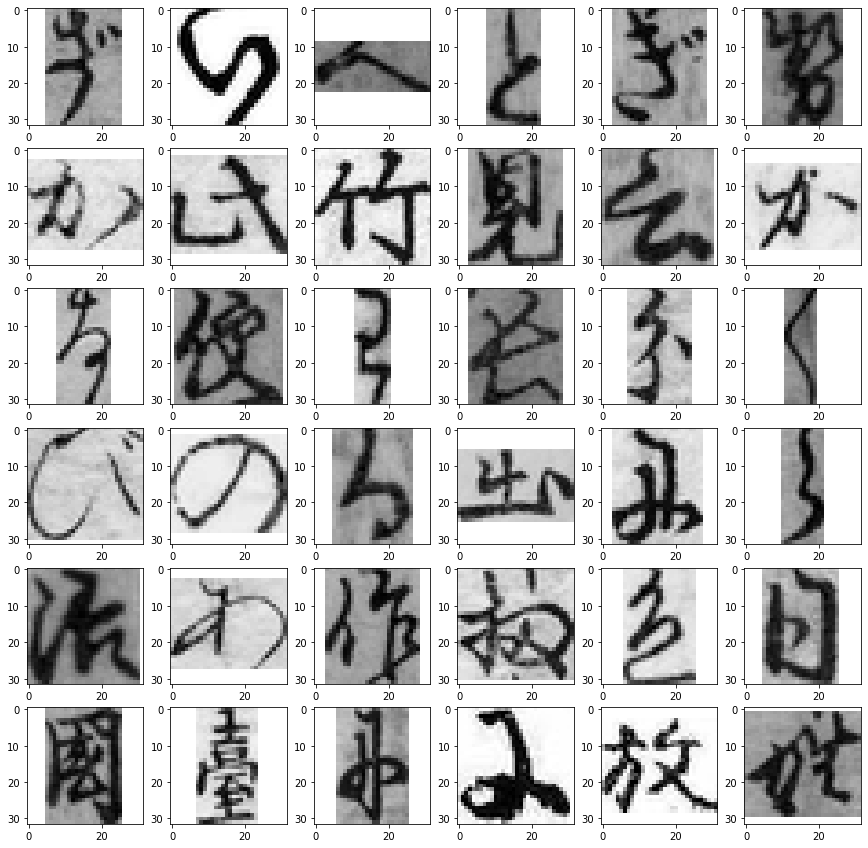

In [7]:
raw = np.load('../data/dataset/test.npz')

nDisp = 6
imageId = np.random.randint(raw['image'].shape[0], size=(nDisp, nDisp))
print(raw['image'].shape, raw['character'].shape, np.unique(raw['character']).shape, raw['characterMap'].shape)
print(np.unique(raw['character']))

plt.figure(figsize=(15,15))
for i in range(nDisp):
    for j in range(nDisp):
        plt.subplot(nDisp, nDisp, i*nDisp+j+1)
        plt.imshow(raw['image'][imageId[i,j],:,:], cmap='gist_gray')
plt.show()

In [8]:
raw['image'].nbytes/1024/1024

667.4453125

In [9]:
raw['character'].nbytes/1024/1024

2.607208251953125

In [10]:
raw['characterMap'].nbytes/1024/1024

3120.1764755249023